# WEBSCRAPING WATER PERMIT DATA

Dependencies: geopandas, bs4, requests, pandas, re, time

Datasource: http://sistemas.meioambiente.mg.gov.br/licenciamento/site/lista-outorgas

## IMPORTING LIBRARIES

In [28]:
import geopandas as gpd
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
import time
import numpy as np

## UNDERSTANDING THE WEBSITE STRUCTURE

### Using Beautiful Soup to get the data

In [5]:
id_inicial = 87
link = f"https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id={id_inicial}"
req_outorga = requests.get(link)
soup = BeautifulSoup(req_outorga.text, 'html.parser')
print(soup)


<!DOCTYPE html>

<html>
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="_csrf" name="csrf-param"/>
<meta content="Zl_RjHtDZXO4K_yDUalwMqW_V2N8tAWXGhFWzmSPfp08E7O_F24CCuBBrLNhwABB1sdgMRKNZNNzXQKhD-gzrQ==" name="csrf-token"/>
<link href="/licenciamento/assets/aefe8ed3/css/bootstrap.css" rel="stylesheet"/>
<link href="/licenciamento/css/site.css" rel="stylesheet"/>
<link href="/licenciamento/font-awesome/css/font-awesome.min.css" rel="stylesheet"/>
<link href="/licenciamento/assets/f3a559d1/css/activeform.min.css" rel="stylesheet"/>
<link href="/licenciamento/assets/d168cc29/css/kv-detail-view.min.css" rel="stylesheet"/>
<link href="/licenciamento/assets/eda7976e/css/bootstrap-dialog-bs3.min.css" rel="stylesheet"/>
<link href="/licenciamento/assets/c5c5ba64/css/kv-widgets.min.css" rel="stylesheet"/>
<style>* { font-size: 12px }</style>
<script src="/licenciamento/assets/eda7976e/js/dialog.min.js"></script>
<script>var kr

### Extracting the main tags

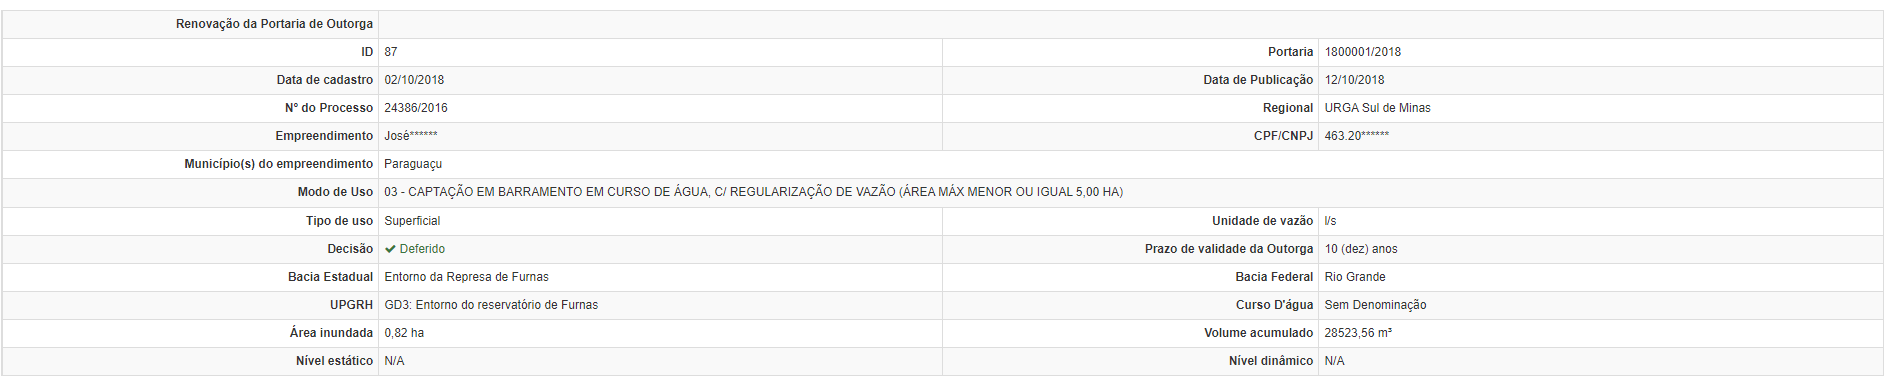

In [6]:
fields_div_tag = soup.find_all('th', {'style': "width: 20%; text-align: right; vertical-align: middle;"})
values_div_tag = soup.find_all('div', {'class': 'kv-attribute'})
# Extract the values
fields = [div.text.strip() for div in fields_div_tag]
values = [div.text.strip() for div in values_div_tag]

data = {column: [value] for column, value in zip(fields, values)}

#data = list(zip(fields, values))
df = pd.DataFrame(data)
df.head()

,Renovação da Portaria de Outorga,ID,Portaria,Data de cadastro,Data de Publicação,Nº do Processo,Regional,Empreendimento,CPF/CNPJ,Município(s) do empreendimento,...,Decisão,Prazo de validade da Outorga,Bacia Estadual,Bacia Federal,UPGRH,Curso D'água,Área inundada,Volume acumulado,Nível estático,Nível dinâmico
0,,87,1800001/2018,02/10/2018,12/10/2018,24386/2016,URGA Sul de Minas,José******,463.20******,Paraguaçu,...,Deferido,10 (dez) anos,Entorno da Represa de Furnas,Rio Grande,GD3: Entorno do reservatório de Furnas,Sem Denominação,"0,82 ha","28523,56 m³",N/A,N/A


### Extracting flow tags

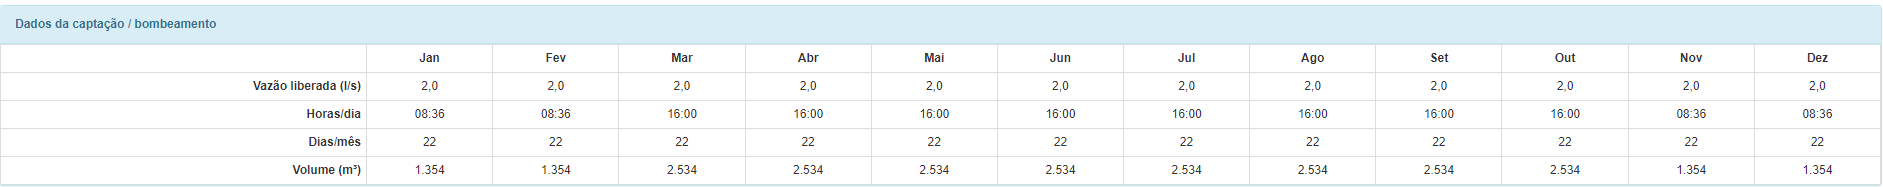

In [15]:
flow_table_tag = soup.find_all('table', {'class': 'table table-condensed table-bordered table-hover no-margin'})
df_flow = pd.read_html('{}'.format(flow_table_tag))
df_flow[0].head()

C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1166754095.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag))


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,Jan,Fev,Mar,Abr,Mai,Jun,Jul,Ago,Set,Out,Nov,Dez
1,Vazão liberada (l/s),20,20,20,20,20,20,20,20,20,20,20,20
2,Horas/dia,08:36,08:36,16:00,16:00,16:00,16:00,16:00,16:00,16:00,16:00,08:36,08:36
3,Dias/mês,22,22,22,22,22,22,22,22,22,22,22,22
4,Volume (m³),1.354,1.354,2.534,2.534,2.534,2.534,2.534,2.534,2.534,2.534,1.354,1.354


In [17]:
df_flow[0].dtypes

0     object
1     object
2     object
3     object
4     object
5     object
6     object
7     object
8     object
9     object
10    object
11    object
12    object
dtype: object

### Extracting coordinates info

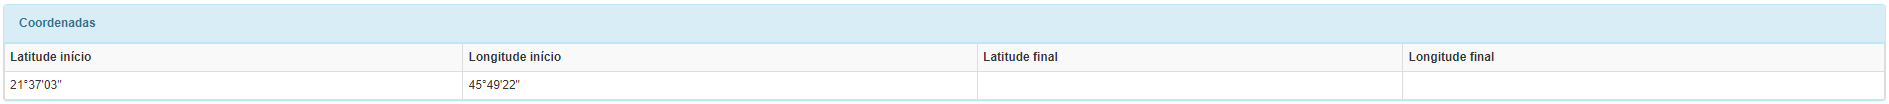

In [19]:
coords_table_tag = soup.find_all('table', {'class': 'table table-bordered table-striped table-condensed no-margin'})
df_coordinates = pd.read_html('{}'.format(coords_table_tag))
df_coordinates[0].head()

C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2400975527.py:2: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coordinates = pd.read_html('{}'.format(coords_table_tag))


,Latitude início,Longitude início,Latitude final,Longitude final
0,"21°37'03""","45°49'22""",NaN,NaN


In [20]:
print(df_coordinates[0].dtypes)

Latitude início      object
Longitude início     object
Latitude final      float64
Longitude final     float64
dtype: object


### Extracting use
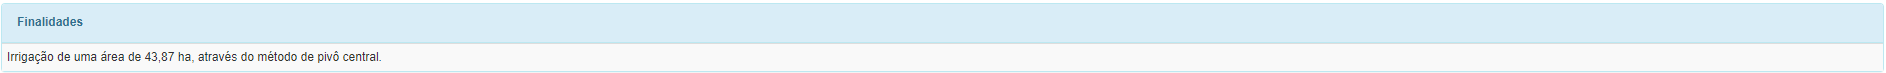

In [14]:
fin_table_tag = soup.find('table', {'class': 'table table-striped table-condensed no-margin'}).find('tr').find('td').text

print(fin_table_tag)

Irrigação de uma área de 43,87 ha, através do método de pivô central.


## DATA WRANGLING METHODS

### Flow

In [25]:
def flow_wrangling(df_flow):
    df_flow[0].columns = df_flow[0].iloc[0]
    df_flow[0].drop(0, axis=0, inplace=True)
    df_flow[0].set_index(df_flow[0].columns[0], inplace=True)
    df_flow[0].columns.name = None
    df_flow = df_flow[0].T
    df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
    return df_flow

### Coordinates

In [23]:
def dmstodd(coordinates):
    #lat = '''51°36'9.18"N'''
    deg, minutes, seconds, direction =  re.split('[°\'"]', coordinates)
    coords=-1*(float(deg) + float(minutes)/60 + float(seconds)/(60*60))
    return coords

In [32]:
id_inicial = 587
id_final = 600
df_outorga_decisao = pd.DataFrame()
for idx_outorga in range(id_inicial, id_final, 1):
    print(idx_outorga)
    link = f"https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id={idx_outorga}"
    print(link)
    req_outorga = requests.get(link)
    if req_outorga.status_code != 200:
        continue
    time.sleep(2)
    soup = BeautifulSoup(req_outorga.text, 'html.parser')

    #-------------------GENERAL COLUMNS--------------------#
    fields_div_tag = soup.find_all('th', {'style': "width: 20%; text-align: right; vertical-align: middle;"})
    values_div_tag = soup.find_all('div', {'class': 'kv-attribute'})
    # Extract the values
    fields = [div.text.strip() for div in fields_div_tag]
    values = [div.text.strip() for div in values_div_tag]
    
    data = {column: [value] for column, value in zip(fields, values)}
    
    #TABLE
    df = pd.DataFrame(data)
    
    #-------------------FLOW COLUMNS--------------------#
    
    flow_table_tag = soup.find_all('table', {'class': 'table table-condensed table-bordered table-hover no-margin'})
    if flow_table_tag == []:
        pass
    else:       
        df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
        df_flow = flow_wrangling(df_flow)
        try:
            df = pd.concat([df, df_flow.loc[[df_flow.iloc[:, 0].idxmax()]].reset_index(drop=True)], axis=1)
        except:
            df = pd.concat([df, df_flow.iloc[[0]].reset_index()], axis=1)
    
    #-------------------COORDINATES COLUMNS--------------------#
    coords_table_tag = soup.find_all('table', {'class': 'table table-bordered table-striped table-condensed no-margin'})
    df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
    df_coords = df_coords[0]

    try:          
        df_coords.iloc[:, 0] = df_coords.iloc[:, 0].str.replace(",", ".").apply(dmstodd)
        df_coords.iloc[:, 1] = df_coords.iloc[:, 1].str.replace(",", ".").apply(dmstodd)
    except (ValueError, TypeError) as e:
        print(f"Não foi possivel arrumar as coordenadas: {e}")
        # Setting specific rows to NaN if there is an error
        df_coords.iloc[:, 0] = df_coords.iloc[:, 0].apply(lambda x: np.nan if isinstance(x, str) and ',' in x else x)
        df_coords.iloc[:, 1] = df_coords.iloc[:, 1].apply(lambda x: np.nan if isinstance(x, str) and ',' in x else x)
    
    df = pd.concat([df, df_coords.iloc[:, :2]], axis=1)
    
    #-------------------FINALIDADE COLUMNS--------------------#
    fin_table_tag = soup.find_all('table', {'class': 'table table-striped table-condensed no-margin'})
    table_fin = pd.read_html('{}'.format(fin_table_tag), thousands='.', decimal=',')[0]
    finalidades = ', '.join(table_fin[0])
    
    df['Finalidade de uso'] = finalidades

    #LINK
    df['Link'] = link

    df_outorga_decisao = pd.concat([df_outorga_decisao, df], axis=0)

587
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=587


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

588
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=588


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

589
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=589


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

590
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=590


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

591
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=591


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

592
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=592


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

593
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=593


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

594
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=594


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

595
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=595


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

596
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=596


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

597
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=597


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

598
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=598


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

599
https://sistemas.meioambiente.mg.gov.br/licenciamento/site/detalhes-outorga?id=599


C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:32: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_flow = pd.read_html('{}'.format(flow_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\2332059671.py:7: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_flow = df_flow.apply(pd.to_numeric, errors='ignore')
C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1795460689.py:41: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df_coords = pd.read_html('{}'.format(coords_table_tag), thousands='.', decimal=',')
C:\Users\alexandre.assuncao\AppDa

In [33]:
df_outorga_decisao

,Renovação da Portaria de Outorga,ID,Portaria,Data de cadastro,Data de Publicação,Nº do Processo,Regional,Empreendimento,CPF/CNPJ,Município(s) do empreendimento,...,Nível dinâmico,Vazão liberada (l/s),Horas/dia,Dias/mês,Volume (m³),Latitude início,Longitude início,Finalidade de uso,Link,Vazão liberada (m³/h)
0,,587,1700501/2018,23/10/2018,25/10/2018,35789/2016,URGA Noroeste de Minas,Fazenda******,501.60******,Paracatu,...,N/A,20.0,20:00,25.0,36000.0,-17.299167,-46.933611,Irrigação de uma área de 15 ha através do méto...,https://sistemas.meioambiente.mg.gov.br/licenc...,NaN
0,,588,1600502/2018,23/10/2018,27/10/2018,38823/2016,URGA Norte de Minas,João******,822.47******,Lassance,...,N/A,270.0,14:00,30.0,408240.0,-17.806075,-44.590417,irrigação de uma área de 100 ha através do mét...,https://sistemas.meioambiente.mg.gov.br/licenc...,NaN
0,0000309/2006,589,1700503/2018,23/10/2018,24/10/2018,01579/2011,URGA Noroeste de Minas,ADM******,36.320******,Buritis,...,"58,0 m",NaN,03:00,31.0,0.0,-15.368611,-46.601944,Consumo humano,https://sistemas.meioambiente.mg.gov.br/licenc...,3.00
0,,590,1500504/2018,23/10/2018,24/10/2018,32275/2015,URGA Leste de Minas,Fazenda******,501.47******,Santa Maria do Suaçuí,...,N/A,11.0,11:30,31.0,14080.0,-18.365833,-42.354444,"Irrigação de uma área de 10,11 ha através do m...",https://sistemas.meioambiente.mg.gov.br/licenc...,NaN
0,,591,1500505/2018,23/10/2018,24/10/2018,02755/2018,URGA Leste de Minas,Fazenda******,02.275******,Frei Inocêncio,...,N/A,179.7,21:00,20.0,271706.0,-18.564167,-41.898611,"Irrigação de uma área de 122,34 ha, através do...",https://sistemas.meioambiente.mg.gov.br/licenc...,NaN
0,,592,1400506/2018,23/10/2018,25/10/2018,40305/2016,URGA Jequitinhonha,Posto******,66.416******,Gouvêa,...,120 m,NaN,13:33,31.0,0.0,-18.443889,-43.736944,"Consumo humano, Consumo industrial",https://sistemas.meioambiente.mg.gov.br/licenc...,1.50
0,,593,1900507/2018,23/10/2018,25/10/2018,27266/2015,URGA Triângulo Mineiro,FAZENDA******,Não informado,Campina Verde,...,"9,7 m",NaN,02:00,31.0,0.0,-19.747778,-50.056944,"Consumo humano 15 pessoas, Consumo industrial",https://sistemas.meioambiente.mg.gov.br/licenc...,6.80
0,,594,1500508/2018,23/10/2018,24/10/2018,33872/2014,URGA Leste de Minas,Heliete******,459.03******,Ipanema,...,N/A,12.0,07:00,3.0,907.0,-19.825556,-41.705278,"Irrigação de pastagens, de uma área de 10,00 h...",https://sistemas.meioambiente.mg.gov.br/licenc...,NaN
0,,595,1900509/2018,23/10/2018,25/10/2018,36401/2016,URGA Triângulo Mineiro,FAZENDA******,Não informado,Serra do Salitre,...,"8,5 m",NaN,00:20,30.0,0.0,-19.152222,-46.655,"Consumo humano 20 pessoas, Consumo agroindustrial",https://sistemas.meioambiente.mg.gov.br/licenc...,6.20
0,0000016/2014,596,1700510/2018,23/10/2018,25/10/2018,27883/2017,URGA Noroeste de Minas,Fazenda******,095.08******,Guarda-Mor,...,N/A,33.0,12:00,6.0,8553.6,-17.657778,-47.050278,Irrigação de uma área de 43 ha através do méto...,https://sistemas.meioambiente.mg.gov.br/licenc...,NaN


In [35]:
gdf = gpd.GeoDataFrame(data=df_outorga_decisao, geometry=gpd.points_from_xy(df_outorga_decisao['Longitude início'], df_outorga_decisao['Latitude início']), crs='EPSG:4674')

<AxesSubplot:>

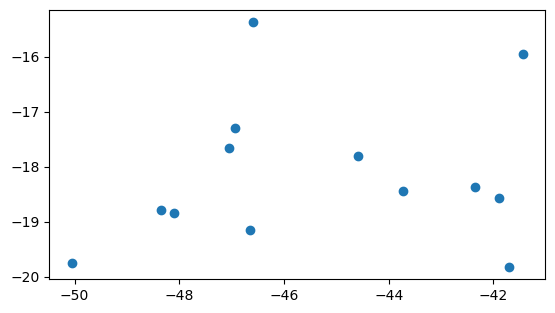

In [36]:
gdf.plot()

In [40]:
gdf.columns

Index(['Renovação da Portaria de Outorga', 'ID', 'Portaria',
       'Data de cadastro', 'Data de Publicação', 'Nº do Processo', 'Regional',
       'Empreendimento', 'CPF/CNPJ', 'Município(s) do empreendimento',
       'Modo de Uso', 'Tipo de uso', 'Unidade de vazão', 'Decisão',
       'Prazo de validade da Outorga', 'Bacia Estadual', 'Bacia Federal',
       'UPGRH', 'Curso D'água', 'Área inundada', 'Volume acumulado',
       'Nível estático', 'Nível dinâmico', 'Vazão liberada (l/s)', 'Horas/dia',
       'Dias/mês', 'Volume (m³)', 'Latitude início', 'Longitude início',
       'Finalidade de uso', 'Link', 'Vazão liberada (m³/h)', 'geometry'],
      dtype='object')

In [69]:
gdf['Volume (m³)']

0     36000.0
0    408240.0
0         0.0
0     14080.0
0    271706.0
0         0.0
0         0.0
0       907.0
0         0.0
0      8553.6
0         0.0
0         0.0
0         0.0
Name: Volume (m³), dtype: float64

In [74]:
import folium
# Create a Folium map centered at the average coordinates of the GeoDataFrame
centroid = gdf.geometry.centroid
center = [centroid.y.mean(), centroid.x.mean()]
folium_map = folium.Map(location=center, zoom_start=6)

# Function to determine marker color based on the 'type' column
def get_marker_color(feature):
    #print(feature['properties']['Tipo de uso'])
    if feature['properties']['Tipo de uso'] == 'Superficial':
        return 'green'
    elif feature['properties']['Tipo de uso'] == 'Subterrâneo':
        return 'blue'
    else:
        return 'gray'  # Default color if type is not recognized

colors = ["orange", "yellow", "green", "blue"] 
# Add GeoDataFrame to the map
folium.GeoJson(
    gdf,
    marker=folium.Marker(icon=folium.Icon(icon='star')),
    name="Water permits",
    style_function=lambda x: {
        "markerColor": get_marker_color(x),
    },
    popup=folium.GeoJsonPopup(fields=[col for col in gdf.columns if col != 'geometry'])
).add_to(folium_map)

# Add layer control to toggle the GeoDataFrame layer
folium.LayerControl().add_to(folium_map)

# Save the map to an HTML file (optional)
folium_map.save("map.html")

# Display the map
folium_map

C:\Users\alexandre.assuncao\AppData\Local\Temp\ipykernel_14168\1558141105.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = gdf.geometry.centroid
